# Day 0
## Exercise 0.14

Consider the linear regression problem (ordinary least squares) on the Galton dataset, with a single response variable
$$
y = \textbf{x}^T\textbf{w} + \epsilon
$$

This is a general problem where

- $\textbf{x}$ is a $D$ dimensional vector
- $y$ is a scalar


The linear regression problem is, given a set 
$$
\{y^{(m)}\}_{m=1}^M
$$

of samples of $y$ and the corresponding $\textbf{x}^{(m)}$ vectors, estimate $\textbf{w}$ to minimise the sum of the $\epsilon$ variables. 

Traditionally this is solved analytically to obtain a closed form solution. Although this is not the way in which it should be computed in this exercise, linear algebra packages have an optimised solver, e.g. numpy.linalg.lstsq.

We can code the prediction of our linear model using a dot product already implemented
in ```np.dot```. In order to do it we can append a column full of ones. 

#### Notes about the implementation for the galton dataset
- We want to model son heights from father heights.


- We will denote the data that has the mentioned appended column as ```ones_X```
    - ```ones_X.shape``` should have shape ```(928, 2)```


- ```ones_x``` will denote a single row of ```ones_X``` which is a $D+1$ dimensional vector
  - Notice that ```ones_x``` can be any for of ```ones_X```, for example the k'th row ```
  ones_X[k]```.
  - It is very important to understand the difference between  ```
  ones_X[k]``` and ```ones_X[k:k+1]```. 
      - ```ones_X[k]``` has ndim 1
      - ```ones_X[k:k+1]``` has ndim 2
   
   
- $y$ is a scalar




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
sys.path.append("../../lxmls-toolkit/")
import matplotlib.pyplot as plt

import lxmls
import lxmls.readers.galton as galton

In [2]:
galton_data = galton.load()

In [3]:
father_height = galton_data[:,0].reshape((len(galton_data),1))
son_height = galton_data[:,1].reshape((len(galton_data),1))

In [4]:
father_height.shape, son_height.shape

((928, 1), (928, 1))

#### Append the column full of ones for the bias term

In [5]:
ones_X = np.hstack((np.ones((father_height.shape[0],1)), father_height))

In [6]:
ones_X.shape

(928, 2)

In [7]:
ones_X

array([[  1. ,  70.5],
       [  1. ,  68.5],
       [  1. ,  65.5],
       ..., 
       [  1. ,  69.5],
       [  1. ,  69.5],
       [  1. ,  69.5]])

In [8]:
Y = son_height

#### 0. Complete the function that produces the predictions for a given observation and a set of weights $w_j$ 

In [9]:
def predict(X, w):
    return np.dot(X, w)

#### Predicting using the linear model


Let us assume we have a dataset with

- $M$ datapoints (number of rows).
- $D$ features (number of columns)

In order to do this exercise we will add a column full of ones at position 0 and get a $M \times (D+1)$.

The predict function will return the prediction of the linear model given

- An input which can be 
    - A single $ (D+1) \times 1$ row vector
    - A matrix of the form $batch \times (D+1)$ where $batch$ is the number of rows in the matrix.
    
- A vector of weights of size $D$

Notice that we have created a new column full of ones  to take into account the bias term of the regressor.



In [10]:
ones_X

array([[  1. ,  70.5],
       [  1. ,  68.5],
       [  1. ,  65.5],
       ..., 
       [  1. ,  69.5],
       [  1. ,  69.5],
       [  1. ,  69.5]])

In [11]:
### test

# these are the gold outputs - we should get this from the predict function
# for the first 3 items
y_hat_3  = np.array([[ 20.8692923 ],
                     [ 20.29701363],
                     [ 19.43859562]])

# let's see if that is the case
np.random.seed(123)
w = np.random.random((2,1))

if np.linalg.norm(y_hat_3 - predict(ones_X[0:3], w)) < 0.00001:
    print("\ntest passed: your predict function seems to be OK ")


test passed: your predict function seems to be OK 


##### 1. Complete the function that compute the cost function for a given set of data and weights of the linear model 


In [12]:
def compute_cost(Y, Y_hat):
    """MSE"""
    return np.mean((Y_hat-Y)**2)

def predict_and_compute_cost(x, y, w):
    """MSE"""
    predictions = predict(x, w)
    cost = np.mean((predictions-y)**2)
    return cost

In [13]:
### test cost function
np.random.seed(123)
w = np.random.random((2,1))

Y_hat = predict(ones_X, w) 

if np.linalg.norm(compute_cost(Y_hat, Y) - 2294.68652697)<0.00001:
    print("\ntest passed: your cost function seems to be OK ")


test passed: your cost function seems to be OK 


##### 2. Derive the partial derivative of the error with respecto to a weight $w_j$ 

In [14]:
def compute_partial_error_wrt_j(X, Y, weights, j):
    return np.mean(2 * (predict(X, weights) - Y) * X[:, [j]], axis=0)

## Optimizing weights using gradient descent

In [15]:
def compute_gradient(X, Y, weights):
    if X.ndim == 1:
        X = np.array([X])
        
    # assume rows in X are datapoints
    num_features = X.shape[1]

    grads = np.zeros((num_features, 1))
    for j in range(num_features):
        grads[j] = compute_partial_error_wrt_j(X, Y, weights, j)
        
    return grads

### Gradient checking

We want to ensure that the computation of the cost with respect to the weights is correct. 

We will build a function that 

- Takes as input a function ``func`` and a point where we will evaluate the gradient of ``func``.
- Computes an approximation of the gradient of a given function


In [16]:
def compute_numerical_gradient(cost_func, w, x, y, eps = 0.000001):
    """
    Compute the gradient of the func with respect to w.
    The function returns a gradient vector of the same size as w
    """
    dim = w.shape[0]
    perturbation_vector = np.zeros(w.shape)
    grads = np.zeros(w.shape)

    for i in range(dim):
        # perturbate the current dimension
        perturbation_vector[i] = eps
        
        # compute the slope: (point+epsilon - point-epsilon)/2epsilon
        err_a = cost_func(x, y, w + perturbation_vector)
        err_b = cost_func(x, y, w - perturbation_vector)
        partial_i = (err_a - err_b) / (2*eps)
        perturbation_vector[i] = 0.
        grads[i] = partial_i
        
    return grads

In [77]:
num_features = ones_X.shape[1] 
np.random.seed(123)
weights = np.random.random((num_features, 1))

## grad using exact formula
exact_gradient = compute_gradient(ones_X, son_height, weights)
print(exact_gradient)

[[  -95.69268136]
 [-6538.89239773]]


In [78]:
num_features = ones_X.shape[1] 
np.random.seed(123)
weights = np.random.random((num_features, 1))
num_grad = compute_numerical_gradient(predict_and_compute_cost, weights, ones_X, son_height, eps=1e-6)
print(num_grad)

[[  -95.6926815 ]
 [-6538.89239766]]


### Gradient descent

In [79]:
# given w_j
def gradient_descent(num_iterations, X, Y, w, learning_rate=0.00001):
    # add column full of ones to X this allow us to take into 
    # account an offset (or bias) term for the linear model
    num_features = X.shape[1] 
    cost_evolution = []
    
    for it in range(num_iterations):
        w = w - learning_rate * compute_gradient(X, Y, w)
        Y_hat = predict(X, w)

        cost = predict_and_compute_cost(X, Y, w)
        cost_evolution.append(cost)

        sys.stdout.write("\rw_hat " + str(float(w[0]))[0:8] +" "+ str(float(w[1]))[0:8]+ \
                         " cost iter " +  str(it) + " is: " + str(cost)[0:5] )
        sys.stdout.flush()
        
    return w, cost_evolution

In [60]:
# We can shuffle the data set to help optimization
dataset = np.hstack([ones_X, Y])
permutation = np.random.permutation(len(dataset))
dataset_shuffled = dataset[permutation]

ones_X_shuf = dataset_shuffled[:,:2]     # X shuffled
Y_shuf = dataset_shuffled[:,2][:, None]  # Y shuffled

In [80]:
# set initial weights

np.random.seed(123)
weights = np.random.random((num_features, 1))

print("Initial weights: \n {}".format(weights))

w_hat, cost_evolution = gradient_descent(10000, ones_X_shuf, Y_shuf, weights, learning_rate = 0.000001)

print("Final weights: \n {}".format(w_hat))


Initial weights: 
 [[ 0.69646919]
 [ 0.28613933]]
w_hat 0.707028 0.986200 cost iter 9999 is: 5.369Final weights: 
 [[ 0.70702834]
 [ 0.98620042]]


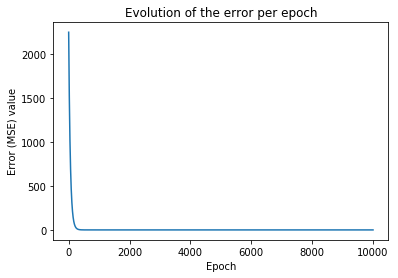

In [81]:
# Plot the value of the cost function per iteration
plt.plot(cost_evolution)
plt.title("Evolution of the error per epoch")
plt.ylabel("Error (MSE) value")
plt.xlabel("Epoch")

In [47]:
w_hat_lstsq = np.linalg.lstsq(a=ones_X, b=son_height)[0]

In [82]:
print("LstSq solution:\n {}".format(w_hat_lstsq))
print("SGD solution:\n {}".format(w_hat))

LstSq solution:
 [[ 23.94153018]
 [  0.64629058]]
SGD solution:
 [[ 0.70702834]
 [ 0.98620042]]


### Plotting the regression

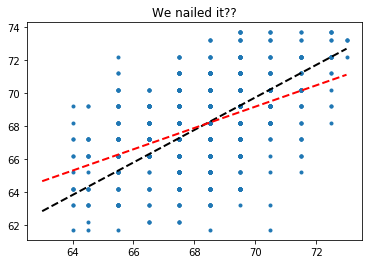

In [83]:
plt.plot(father_height,son_height, ".")
plt.title("We nailed it??")
maxim, minim = int(np.max(father_height)), int(np.min(father_height))
xvals = [vec for vec in np.array(range(minim-1, maxim+1)) ]

# Gradient descent solution
yvals = [ w_hat[1]  * xval + w_hat[0] for xval in xvals]



# solution from closed form
yvals2 = [ w_hat_lstsq[1]  * xval + w_hat_lstsq[0] for xval in xvals]

plt.plot(xvals, yvals, '--', c='k',linewidth=2)
plt.plot(xvals, yvals2, '--', c='r',linewidth=2)

### Add jitter to  see points that are "superposed"

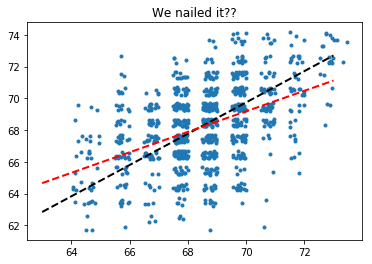

In [84]:
plt.plot(father_height+np.random.random(father_height.shape)/2.,
         son_height+np.random.random(father_height.shape)/2., ".")
plt.title("We nailed it??")
maxim, minim = int(np.max(father_height)), int(np.min(father_height))
xvals = [vec for vec in np.array(range(minim-1, maxim+1)) ]

# Gradient descent solution
yvals = [ w_hat[1]  * xval + w_hat[0] for xval in xvals]

# solution from closed form
yvals2 = [ w_hat_lstsq[1]  * xval + w_hat_lstsq[0] for xval in xvals]

plt.plot(xvals, yvals, '--', c='k',linewidth=2)
plt.plot(xvals, yvals2, '--', c='r',linewidth=2)